In [349]:
import numpy as np
import pandas as pd

In [350]:
customers = pd.read_csv('../data/cust_demographics.csv')
claims = pd.read_csv('../data/claims.csv')

In [351]:
customers.head()

,CUST_ID,gender,DateOfBirth,State,Contact,Segment
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver
2,30308357,Female,11-Mar-84,TN,798-631-4758,Silver
3,47830476,Female,01-May-86,MA,413-187-7945,Silver
4,19269962,Male,13-May-77,NV,956-871-8691,Gold


In [352]:
claims.head()

,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,54004764,21868593,Driver error,11/27/2017,Auto,No,Material only,$2980,1,No
1,33985796,75740424,Crime,10/03/2018,Home,Unknown,Material only,$2980,3,No
2,53522022,30308357,Other driver error,02/02/2018,Auto,No,Material only,$3369.5,1,Yes
3,13015401,47830476,Natural causes,06/17/2018,Auto,No,Material only,$1680,1,No
4,22890252,19269962,Crime,01/13/2018,Auto,No,Material only,$2680,1,No


In [353]:
#Mapping month name to number
month_map = {'Jan':1,
            'Feb':2,
            'Mar':3,
            'Apr':4,
            'May':5,
            'Jun':6,
            'Jul':7,
            'Aug':8,
            'Sep':9,
            'Oct':10,
            'Nov':11,
            'Dec':12}

In [354]:
# function to calculate age
from datetime import date

def calculate_age(birth):
    birthdate = int(birth.split('-')[0])
    birthmonth = int(month_map.get(birth.split('-')[1]))
    birthyear =  int(birth.split('-')[2])
    today = date.today() 
    if birthyear > today.year%100:
        birthyear = birthyear + 1900
    else:
        birthyear = birthyear + 2000
    
    born = date(birthyear,birthmonth,birthdate)
    try:  
        birthday = born.replace(year = today.year) 
  
    # raised when birth date is February 29 
    # and the current year is not a leap year 
    except ValueError:  
        birthday = born.replace(year = today.year, 
                  month = born.month + 1, day = 1) 
  
    if birthday > today: 
        return today.year - born.year - 1
    else: 
        return today.year - born.year 
    

In [357]:
customers['customer_age'] = customers['DateOfBirth'].apply(calculate_age)
customers.head()

,CUST_ID,gender,DateOfBirth,State,Contact,Segment,customer_age
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum,40
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver,49
2,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,35
3,47830476,Female,01-May-86,MA,413-187-7945,Silver,33
4,19269962,Male,13-May-77,NV,956-871-8691,Gold,42


In [358]:
claims_per_customers = pd.merge(customers,claims,left_on = 'CUST_ID', right_on = 'customer_id')
del claims_per_customers['customer_id']

In [359]:
claims_per_customers.head()

,CUST_ID,gender,DateOfBirth,State,Contact,Segment,customer_age,claim_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum,40,54004764,Driver error,11/27/2017,Auto,No,Material only,$2980,1,No
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver,49,33985796,Crime,10/03/2018,Home,Unknown,Material only,$2980,3,No
2,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,35,53522022,Other driver error,02/02/2018,Auto,No,Material only,$3369.5,1,Yes
3,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,35,63017412,Driver error,04/04/2018,Auto,No,Material only,$1950,6,No
4,47830476,Female,01-May-86,MA,413-187-7945,Silver,33,13015401,Natural causes,06/17/2018,Auto,No,Material only,$1680,1,No


In [360]:
#segregate population into different categories based on age 
def population_category(age):
    if age < 18:
        return 'Children'
    elif age < 30:
        return 'Youth'
    elif age < 60:
        return 'Adult'
    else:
        return 'Senior'

In [361]:
claims_per_customers['population_category'] = claims_per_customers['customer_age'].apply(population_category)

In [362]:
claims_per_customers['claim_amount'] = claims_per_customers['claim_amount'].replace('[\$,]', '', regex=True).astype(float)

In [363]:
avg_claim_per_segment = claims_per_customers.groupby('Segment',as_index = False).agg({'claim_amount':'mean'})
avg_claim_per_segment

,Segment,claim_amount
0,Gold,12731.532086
1,Platinum,12367.009722
2,Silver,11935.429598


In [364]:
import matplotlib.pyplot as plt
%matplotlib inline

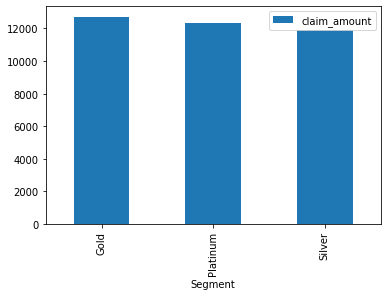

In [365]:
avg_claim_per_segment.plot.bar(x = 'Segment',y='claim_amount');

In [366]:
# number of adults from AK,DE,TX who have driver related incident claims

claims_driver_error = claims_per_customers[claims_per_customers['incident_cause'].isin(['Driver error','Other driver error'])]
adult_claims_driver_error = pd.DataFrame(claims_driver_error.groupby(['population_category','State'],as_index=False).size()).reset_index()
adult_claims_driver_error.rename(columns = {0:'total_claims'}, inplace = True)
adult_claims_driver_error[(adult_claims_driver_error['population_category'] =='Adult') & (adult_claims_driver_error['State'].isin(['TX','DE','AK']))]

,population_category,State,total_claims
0,Adult,AK,9
7,Adult,DE,10
42,Adult,TX,8


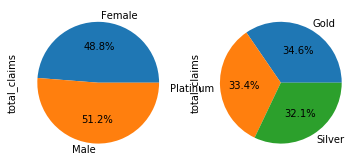

In [367]:
# use pie chart to represent percentage of claims by gender and segment
claims_per_gender = pd.DataFrame(claims_per_customers.groupby(['gender'],as_index=False).size().reset_index())
claims_per_gender.rename(columns = {0:'total_claims'}, inplace = True)
claims_per_segment = pd.DataFrame(claims_per_customers.groupby(['Segment'],as_index=False).size().reset_index())
claims_per_segment.rename(columns = {0:'total_claims'}, inplace = True)

fig1, ax = plt.subplots(nrows=1,ncols=2)
claims_per_gender.plot(kind='pie', y = 'total_claims', autopct='%1.1f%%',ax= ax[0], 
 labels=claims_per_gender['gender'],  legend = False, fontsize=10);
claims_per_segment.plot(kind='pie', y = 'total_claims', autopct='%1.1f%%', ax = ax[1],
 labels=claims_per_segment['Segment'],  legend = False, fontsize=10);

,population_category,non_fraud_claims
0,Adult,612
1,Youth,226


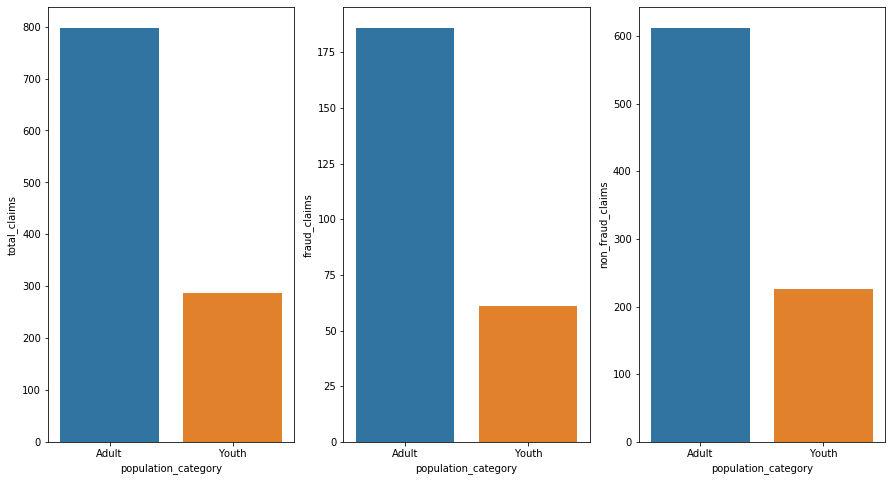

In [420]:
#most fraudulent policy claims
import seaborn as sns
#plt.figure(17,10)
fig , ax = plt.subplots(1,3,figsize=(15,8))

# #total claims
total_claims = claims_per_customers.groupby(['population_category']).size().reset_index(name='total_claims')
sns.barplot(x = 'population_category', y ='total_claims', data = total_claims , ax= ax[0]);
total_claims

# Fraudulent claims
fraudulent_claims = claims_per_customers[claims_per_customers['fraudulent']=='Yes']
fraudulent_claims = fraudulent_claims.groupby(['population_category']).size().reset_index(name='fraud_claims')
sns.barplot(x = 'population_category', y ='fraud_claims', data = fraudulent_claims, ax=ax[1]);

# Non-Fraudulent claims
non_fraudulent_claims = claims_per_customers[claims_per_customers['fraudulent']=='No']
non_fraudulent_claims = non_fraudulent_claims.groupby(['population_category']).size().reset_index(name='non_fraud_claims')
sns.barplot(x = 'population_category', y ='non_fraud_claims', data = non_fraudulent_claims, ax=ax[2]);
non_fraudulent_claims

In [400]:
#claims_per_customers['claim_month'] = int(month_map.get(claims_per_customers['claim_date'].split('-')[1]))
claims_per_customers['claim_month'] = claims_per_customers['claim_date'].apply(lambda x: x.split('/')[0])
claims_per_customers['claim_year'] = claims_per_customers['claim_date'].apply(lambda x: x.split('/')[2])


,CUST_ID,gender,DateOfBirth,State,Contact,Segment,customer_age,claim_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent,population_category,claim_month,claim_year
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum,40,54004764,Driver error,11/27/2017,Auto,No,Material only,2980.0,1,No,Adult,11,2017
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver,49,33985796,Crime,10/03/2018,Home,Unknown,Material only,2980.0,3,No,Adult,10,2018
2,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,35,53522022,Other driver error,02/02/2018,Auto,No,Material only,3369.5,1,Yes,Adult,02,2018
3,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,35,63017412,Driver error,04/04/2018,Auto,No,Material only,1950.0,6,No,Adult,04,2018
4,47830476,Female,01-May-86,MA,413-187-7945,Silver,33,13015401,Natural causes,06/17/2018,Auto,No,Material only,1680.0,1,No,Adult,06,2018


In [413]:
claims_2017 = claims_per_customers[claims_per_customers['claim_year']=='2017']
claim_by_period = claims_2017.groupby(['claim_month','claim_year'],as_index=False).agg({'claim_amount':'sum'})[['claim_month','claim_year','claim_amount']]
#claim_by_period = claims_per_customers.groupby('claim_month',as_index=False).agg({'claim_amount':'sum'})[['claim_month','claim_amount']]
claim_by_period

,claim_month,claim_year,claim_amount
0,01,2017,608157.5
1,02,2017,613168.0
2,03,2017,612153.0
3,04,2017,763154.0
4,05,2017,535879.0
5,06,2017,563942.0
6,07,2017,799776.5
7,08,2017,424113.0
8,09,2017,416137.0
9,10,2017,635490.5


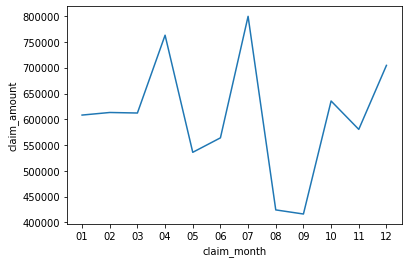

In [414]:
sns.lineplot(x='claim_month', y= 'claim_amount', data =claim_by_period);
#sns.lineplot?